<a href="https://colab.research.google.com/github/Nadine305/Facial-Expression-Recognition/blob/main/Preprocessing_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load the data from kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:00<00:00, 151MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


# 1. preprocessing

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
def apply_clahe(img):
    """Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to the image."""
    img = np.uint8(img)  # Ensure uint8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)



In [5]:
def denoise_image(img):
    """Apply a denoising filter (Gaussian blur) to the image."""
    return cv2.GaussianBlur(img, (5, 5), 0)



In [6]:
def apply_histogram_stretching(img):
    """Apply histogram stretching to enhance image contrast."""
    min_val = np.min(img)
    max_val = np.max(img)
    if min_val == max_val:
        return img
    return ((img - min_val) / (max_val - min_val) * 255).astype(np.uint8)

In [7]:


def normalize_image(img):
    """Normalize the image to a range of [0, 255] and ensure uint8 type."""
    return np.uint8(img)


In [8]:

def sharpen_image(img):
    """Sharpen the image using a kernel filter."""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

In [9]:


def apply_gamma_correction(img, gamma=1.5):
    """Apply gamma correction to adjust brightness."""
    img = img / 255.0
    corrected = np.power(img, gamma)
    return np.uint8(np.clip(corrected * 255, 0, 255))


In [10]:
def augment_image(img):
    augmented_images = []

    # Original
    augmented_images.append(img)

    # Horizontal flip
    flipped = cv2.flip(img, 1)
    augmented_images.append(flipped)

    # Rotation
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows))
    augmented_images.append(rotated)

    # Brightness adjustment
    brighter = cv2.convertScaleAbs(img, alpha=1.2, beta=30)
    augmented_images.append(brighter)

    return augmented_images


# 2.Feature Extraction

## 2.1 HOG Feature Extraction
 Histogram of oriented gradients

each block has 2*2 cells
each cell has 8*8 pixel

In [11]:
def extract_hog_features(image):
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

In [22]:
def visualize_hog(img):
    features, hog_image = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title("HOG Visualization")
    plt.axis('off')
    plt.show()


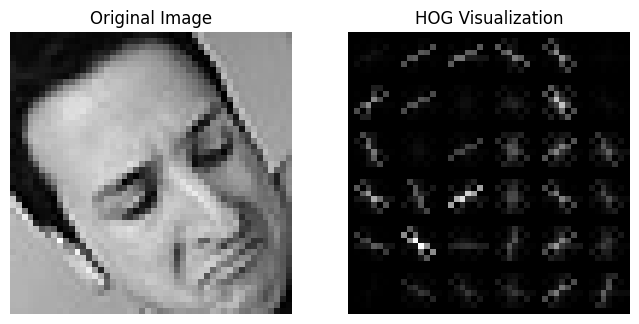

In [28]:
img = cv2.imread("/kaggle/input/fer2013/train/disgust/Training_10371709.jpg", cv2.IMREAD_GRAYSCALE)
visualize_hog(img)

## 2.2 LBP

# Preprocessing + Feature Extraction


In [12]:
def load_and_preprocess_images(folder_path):
    """Load and preprocess images from a given folder."""
    features = []
    labels = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"Warning: Skipped unreadable image {img_path}")
                    continue

                augmented_imgs = augment_image(img)

                for aug_img in augmented_imgs:

                    # Preprocessing pipeline
                    img = apply_clahe(img)
                    img = denoise_image(img)
                    img = apply_histogram_stretching(img)
                    img = apply_gamma_correction(img, gamma=1.5)
                    img = sharpen_image(img)
                    img = normalize_image(img)



                    #lbp_features = extract_lbp_features(img)
                    hog_features = extract_hog_features(img)

                    combined_features = np.hstack([hog_features])

                    features.append(combined_features)
                    labels.append(label)




    return np.array(features), np.array(labels)

In [13]:
train_folder = path+'/train'
test_folder = path+'/test'

print("Loading and preprocessing training images...")
X_train, y_train = load_and_preprocess_images(train_folder)

print("Loading and preprocessing testing images...")
X_test, y_test = load_and_preprocess_images(test_folder)



Loading and preprocessing training images...
Loading and preprocessing testing images...


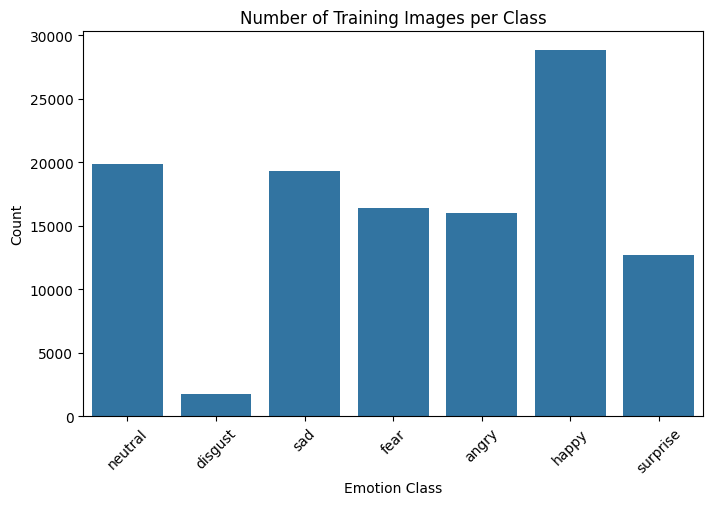

In [14]:
import seaborn as sns
import pandas as pd

df_labels = pd.DataFrame({"label": y_train})
plt.figure(figsize=(8, 5))
sns.countplot(x="label", data=df_labels)
plt.title("Number of Training Images per Class")
plt.xlabel("Emotion Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# 3. classification

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_train)


In [16]:
X_train

array([[ 0.30599825, -0.91520038, -0.0922453 , ..., -0.71335502,
        -0.81264346,  0.00598207],
       [-1.07888025, -0.04979732, -0.31304342, ..., -0.2482508 ,
        -0.70501519, -0.11824951],
       [-0.29192258, -0.41549812, -0.47349331, ..., -0.48406699,
        -0.48816105, -0.78755183],
       ...,
       [-1.02304434, -1.3685014 , -0.77386825, ...,  0.96217552,
        -0.81042081, -0.69597672],
       [ 0.12235474, -1.37486562, -0.2134213 , ...,  1.32519256,
        -0.77230326, -0.82493152],
       [ 0.54079392, -1.05669335, -0.66199775, ...,  2.38226786,
        -0.32600751, -1.13742993]])

In [17]:
X_test

array([[-1.21980517,  1.40497111,  0.96801313, ..., -0.35670049,
         0.82632748,  1.52161477],
       [ 0.30019077,  1.20164471,  1.7115438 , ..., -0.3539342 ,
         0.5375042 ,  1.40344959],
       [ 0.12855524,  1.25308841,  1.76552601, ...,  0.31135097,
         0.38755716,  0.86548776],
       ...,
       [ 0.23137518, -0.47240085,  0.47694321, ..., -0.92433641,
        -0.60495393,  0.11027379],
       [ 0.19361353, -0.7497112 ,  0.56021103, ..., -0.92433641,
         0.03110435, -0.57326059],
       [ 0.17622616, -0.93311275,  0.84744372, ..., -0.92433641,
        -0.21614964,  0.50508413]])

In [25]:
X_pca

array([[ 2.02719966, -6.25251082, -6.28159311,  4.60294253],
       [ 2.61957031, -5.61009973, -7.39083182,  2.24839012],
       [ 2.43678254, -6.27349209, -8.49826658,  0.12006567],
       ...,
       [ 6.68508798,  6.22798149,  7.88839734,  1.25988709],
       [ 6.53511136,  5.81982443,  8.03227911,  1.5540092 ],
       [ 7.1112427 ,  5.04535919,  6.65036106,  1.34158427]])

# image display functions

In [18]:
def load_raw_images(folder_path):
    """Load original grayscale images and labels from folder without preprocessing."""
    images = []
    labels = []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"Warning: Skipped unreadable image {img_path}")
                    continue

                images.append(img)
                labels.append(label)

    return images, labels


In [19]:
def compare_before_after_preprocessing(img, preprocessed_img, label):
    """Compare an original image with its preprocessed version."""
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original - Label: {label}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_img, cmap='gray')
    plt.title("Preprocessed")
    plt.axis('off')

    plt.show()

In [20]:
def test_preprocessing_comparison(X, y, num_samples=5):
    """Display original and preprocessed images side by side."""
    for i in range(num_samples):
        original_img = X[i]

        preprocessed_img = apply_clahe(original_img)
        preprocessed_img = denoise_image(preprocessed_img)
        preprocessed_img = apply_histogram_stretching(preprocessed_img)
        preprocessed_img = apply_gamma_correction(preprocessed_img, gamma=1.5)
        preprocessed_img = sharpen_image(preprocessed_img)
        preprocessed_img = normalize_image(preprocessed_img)

        compare_before_after_preprocessing(original_img, preprocessed_img, y[i])

## Display original and preprocessed images side by side.


Testing preprocessing comparison on training samples...
Testing preprocessing comparison on testing samples...


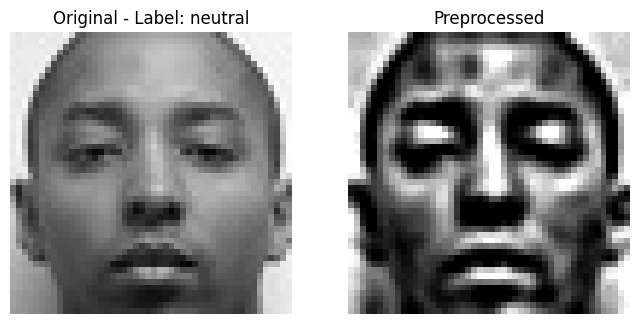

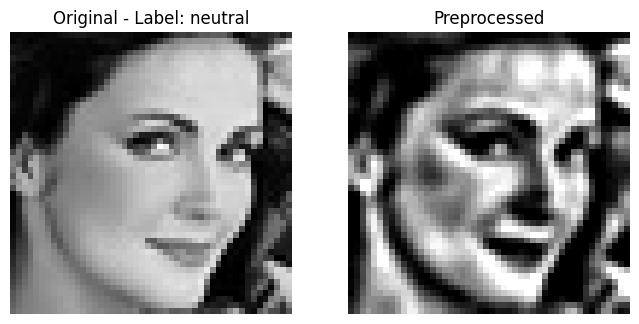

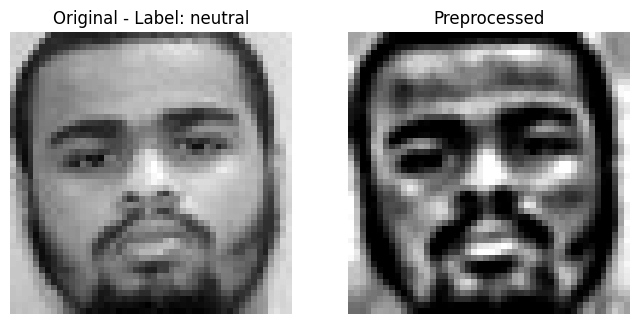

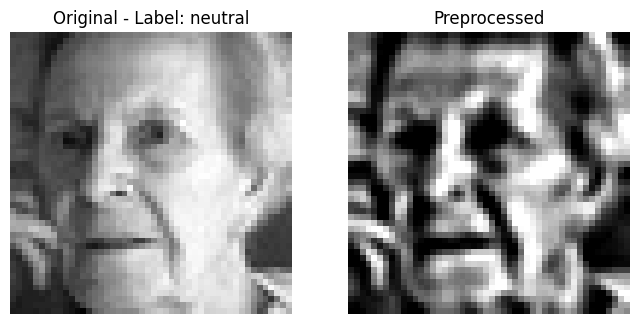

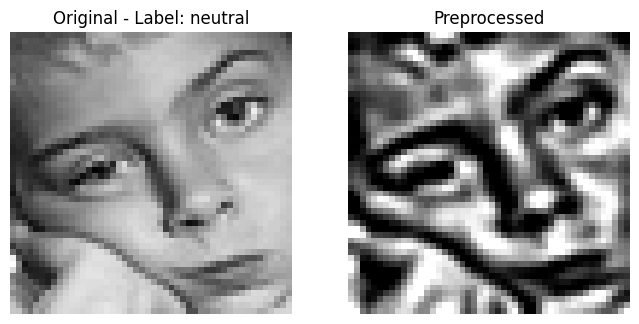

In [21]:

print("Testing preprocessing comparison on training samples...")
raw_train_images, raw_train_labels = load_raw_images(train_folder)

print("Testing preprocessing comparison on testing samples...")
raw_test_images, raw_test_labels = load_raw_images(test_folder)
test_preprocessing_comparison(raw_test_images, raw_test_labels, num_samples=5)

